<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from collections import Counter

In [ ]:
base_folder = "D:/Data1"
fundus_folder = os.path.join(base_folder, "Fundus")
non_fundus_folder = os.path.join(base_folder, "Non Fundus")
duplicates_folder = "D:/Data1/duplicates"


os.makedirs(duplicates_folder, exist_ok=True)

def calculate_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicates(folder):
    hashes = {}
    duplicates = []
    for root, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            img_hash = calculate_hash(file_path)
            if img_hash in hashes:
                duplicates.append(file_path)
            else:
                hashes[img_hash] = file_path
    return duplicates


In [ ]:
def visualize_class_distribution(title):
    counts = {
        "fundus": len(os.listdir(fundus_folder)),
        "non_fundus": len(os.listdir(non_fundus_folder))
    }
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'red'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.show()


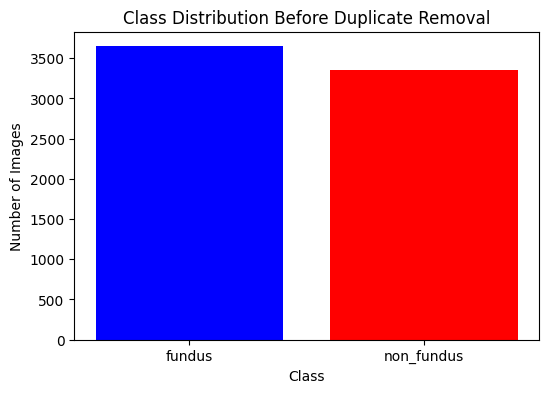

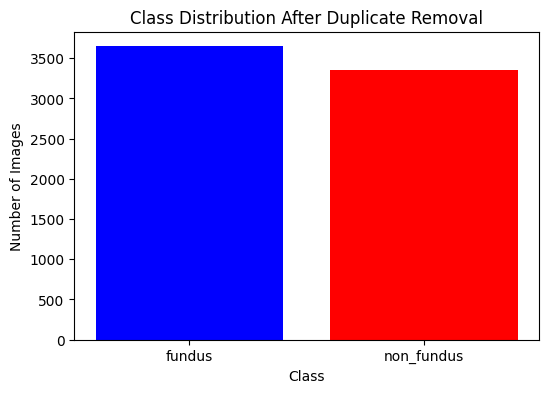

No duplicates found after removal.
Moved 0 duplicate images to 'duplicates' folder.


In [ ]:
visualize_class_distribution("Class Distribution Before Duplicate Removal")

fundus_duplicates = find_duplicates(fundus_folder)
non_fundus_duplicates = find_duplicates(non_fundus_folder)

for duplicate in fundus_duplicates + non_fundus_duplicates:
    shutil.move(duplicate, os.path.join(duplicates_folder, os.path.basename(duplicate)))

visualize_class_distribution("Class Distribution After Duplicate Removal")

remaining_fundus_duplicates = find_duplicates(fundus_folder)
remaining_non_fundus_duplicates = find_duplicates(non_fundus_folder)

if remaining_fundus_duplicates or remaining_non_fundus_duplicates:
    print("Warning: Some duplicates may still be present.")
    print(f"Remaining fundus duplicates: {len(remaining_fundus_duplicates)}")
    print(f"Remaining non-fundus duplicates: {len(remaining_non_fundus_duplicates)}")
else:
    print("No duplicates found after removal.")

print(f"Moved {len(fundus_duplicates) + len(non_fundus_duplicates)} duplicate images to '{duplicates_folder}' folder.")

Found 5598 validated image filenames.
Found 1400 validated image filenames.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5920 - loss: 0.3277
Epoch 1: val_accuracy improved from -inf to 0.47857, saving model to D:/best_fundus_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.5923 - loss: 0.3275 - val_accuracy: 0.4786 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7652 - loss: 0.2256
Epoch 2: val_accuracy did not improve from 0.47857
175/175 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7652 - loss: 0.2256 - val_accuracy: 0.4786 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7944 - loss: 0.1990
Epoch 3: val_accuracy did not improve from 0.47857
175/175 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7945 - loss: 0.1989 - val_accuracy: 0.4786 - val_loss: 1.9063 - learning_rate: 1.0000e-04
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8284 - loss: 0.1776
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_accuracy did not improve from 0.47857
175/175 ━━━━━━━━━━━━━━━━━━━━ 890s 5s/step - accuracy: 0.8284 - loss: 0.1776 -

175/175 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.8595 - loss: 0.1544 - val_accuracy: 0.9736 - val_loss: 0.1762 - learning_rate: 5.0000e-05
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8823 - loss: 0.1370
Epoch 6: val_accuracy did not improve from 0.97357
175/175 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8823 - loss: 0.1371 - val_accuracy: 0.4786 - val_loss: 2.0198 - learning_rate: 5.0000e-05
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8846 - loss: 0.1332
Epoch 7: val_accuracy did not improve from 0.97357
175/175 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8845 - loss: 0.1332 - val_accuracy: 0.8793 - val_loss: 0.2680 - learning_rate: 5.0000e-05
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8855 - loss: 0.1300
Epoch 8: val_accuracy did not improve from 0.97357
175/175 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.8855 - loss: 0.1300 - val_accuracy: 0.9700 - val_loss: 0.0937 - learning_rate: 5.0000e-05
Epoch 9/

175/175 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.8993 - loss: 0.1164 - val_accuracy: 0.9793 - val_loss: 0.1142 - learning_rate: 5.0000e-05
Epoch 11/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9045 - loss: 0.1141
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 11: val_accuracy did not improve from 0.97929
175/175 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9045 - loss: 0.1141 - val_accuracy: 0.9757 - val_loss: 0.1083 - learning_rate: 5.0000e-05
Epoch 12/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1064
Epoch 12: val_accuracy improved from 0.97929 to 0.98000, saving model to D:/best_fundus_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9091 - loss: 0.1065 - val_accuracy: 0.9800 - val_loss: 0.1153 - learning_rate: 2.5000e-05
Epoch 13/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9210 - loss: 0.0969
Epoch 13: val_accuracy did not improve from 0.98000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1061s 6s/step - accuracy: 0.9209 - loss: 0.0970 - val_accuracy: 0.9729 - val_loss: 0.0865 - learning_rate: 2.5000e-05
Epoch 14/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9138 - loss: 0.0997
Epoch 14: val_accuracy did not improve from 0.98000
175/175 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9138 - loss: 0.0997 - val_accuracy: 0.9579 - val_loss: 0.1230 - learning_rate: 2.5000e-05
Epoch 15/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9271 - loss: 0.0952
Epoch 15: val_accuracy did not improve from 0.98000
175/175 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9270 - loss: 0.0952 - val_accuracy: 0.9671 - val_loss: 0.0987 - learning_rate: 2.5000e-05



219/219 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9722 - loss: 0.0857

Final Test Accuracy: 0.9816
219/219 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step


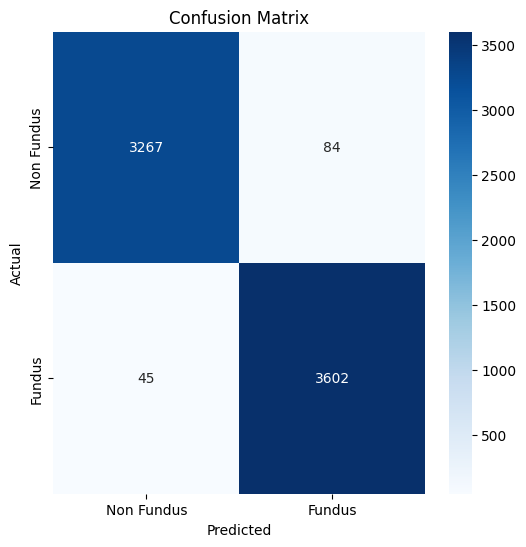


Classification Report:
              precision    recall  f1-score   support

  Non Fundus       0.99      0.97      0.98      3351
      Fundus       0.98      0.99      0.98      3647

    accuracy                           0.98      6998
   macro avg       0.98      0.98      0.98      6998
weighted avg       0.98      0.98      0.98      6998



In [ ]:
DATASET_PATH = "D:/Data1"
MODEL_SAVE_PATH = "D:/best_fundus_model.h5"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4

def load_dataset(dataset_path):
    files, labels = [], []
    for category in ["Non Fundus", "Fundus"]:
        category_path = os.path.join(dataset_path, category)
        for file in os.listdir(category_path):
            files.append(os.path.join(category_path, file))
            labels.append(0 if category == "Non Fundus" else 1)
    return np.array(files), np.array(labels)


def data_generators():
    train_gen = ImageDataGenerator(rescale=1.0 / 255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
    val_test_gen = ImageDataGenerator(rescale=1.0 / 255)
    return train_gen, val_test_gen


def model():
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])
    return model

def compute_class_weights(labels):
    counter = Counter(labels)
    weight_0 = counter[1] / (counter[1] + counter[0])
    weight_1 = counter[0] / (counter[1] + counter[0])
    return {0: weight_0, 1: weight_1}

def model_train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    train_gen, val_test_gen = data_generators()

    train_generator = train_gen.flow_from_dataframe(
        pd.DataFrame({"filename": X_train, "class": y_train}),
        x_col="filename", y_col="class", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="raw"
    )

    val_generator = val_test_gen.flow_from_dataframe(
        pd.DataFrame({"filename": X_val, "class": y_val}),
        x_col="filename", y_col="class", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="raw", shuffle=False
    )

    model = model()
    class_weight = compute_class_weights(y_train)

    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)

    model.fit(train_generator,validation_data=val_generator,epochs=EPOCHS,class_weight=class_weight,callbacks=[early_stopping, reduce_lr, checkpoint],)
    print("\nModel training complete. Best model saved at:", MODEL_SAVE_PATH)


def evaluate_model(X, y):
    test_gen = data_generators()[1].flow_from_dataframe(pd.DataFrame({"filename": X, "class": y}),x_col="filename", y_col="class", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="raw", shuffle=False)

    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    test_loss, test_acc = best_model.evaluate(test_gen)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    y_pred_prob = best_model.predict(test_gen).flatten()
    optimal_threshold = 0.5
    y_pred = (y_pred_prob > optimal_threshold).astype(int)

    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Fundus", "Fundus"], yticklabels=["Non Fundus", "Fundus"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=["Non Fundus", "Fundus"]))

if __name__ == "__main__":
    X, y = load_dataset(DATASET_PATH)
    model_train(X, y)
    evaluate_model(X, y)
